### Volume analysis through Nup133 labeling
Script that aims to analyze cell microscopy data in order to gain insight into cell volume dynamics.
Made by Olle de Jong, based on preexisting microscopy analysis files by Luc-Alban Vuillemenot.

In [99]:
""" Imports """
import os
import random
import re
import copy
from math import pi, sin, cos
import pandas as pd
import numpy as np
import cv2
import matplotlib as mpl
import statistics
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.ndimage import center_of_mass, binary_erosion
import seaborn as sns
from skimage import io, exposure, data
from skimage.io import imread, imshow
from skimage.filters import threshold_local, threshold_otsu, try_all_threshold, threshold_minimum, threshold_yen, rank
from skimage.morphology import remove_small_objects, disk
import bottleneck as bn
%matplotlib inline
plt.style.use('seaborn-v0_8')

In [2]:
""" Globals """
# globally define bottleneck 'nanmean' estimator
nan_mean = bn.nanmean

# IMPORTANT PATHS
# Data files
data_dir = "/Users/olledejong/Studie/MSc Biology/Research Project V1/Code and data/Data"
tiff_files_dir = data_dir + "/processed_tiffs_nup133/"  # relative path from data directory to tiff directory
img_output_dir = data_dir + "/Output/"  # relative path from data directory to image output directory
# Data sheets
budj_data_folder = data_dir + "/Other/Nup133/BudJ/"  # folder that holds the BudJ info on all cells
budding_data_path = data_dir + "/Other/Nup133/buddings.txt"  # budding events
kario_data_path = data_dir + "/Other/Nup133/kariokinesis.txt"  # kariokinesis events

# thresholding globals
scaling_factor = 0.16  # microns per pixel ---> 100x objective
bloc_size_frac_to_use = 0.09
offset_to_use = -50

Now we define a couple of functions that will be used throughout the analysis process. There's a function for time conversion from 'frame' time to real time, since one frame is equal to 5 real time minutes. For function descriptions, see the function's docstring.

In [3]:
def ellipse_from_budj(t, cell_data, scaling_factor):
    """
    Define the function that can extract parameters of the ellipse using the data
    Function to extract parameters of the ellipse from the BudJ table
    """
    data_at_frame = cell_data[cell_data["TimeID"] == t]
    x_pos = float(data_at_frame['x']) / scaling_factor
    y_pos = float(data_at_frame['y']) / scaling_factor
    majorR = float(data_at_frame["Major R"]) / scaling_factor
    minorR = float(data_at_frame["Minor r"]) / scaling_factor
    angle = float(data_at_frame['Angle']) * (pi / 180)  # convert to radians
    return x_pos, y_pos, majorR, minorR, angle

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def plot_from_list(fig_title, data_list, xlim, ylim, save_fig=False, filename="test.png"):
    """
    Given a dictionary that holds image data, plot those in one figure
    """
    if save_fig:
        plt.ioff()
    fig = plt.figure(
        figsize=(4 * len(data_list), 4.2),
        edgecolor="black",
        frameon=True,
        facecolor="white",
        layout="tight"
    ).suptitle(fig_title, fontsize=14, y=1)
    i = 1
    for data in data_list:
        subplt = plt.subplot(1, len(data_list), i)
        subplt.set_title(label=data[0], y=1.02)
        plt.imshow(data[1], cmap="hot")
        subplt.grid(False)
        plt.xlim(xlim)
        plt.ylim(ylim)
        i += 1
    if save_fig:
        plt.savefig(img_output_dir + filename)
    else:
        plt.show()

In [19]:
"""Conversion from TimeIDs to time points in minutes """
TimeIDs = 150
time_step = 5

TimeIDs = range(1, TimeIDs + 1, 1) #+1 because the last number is not accounted
time_mins = []

for i in TimeIDs:
    t = time_step*(i-1)
    time_mins.append(t)

time_conversion = pd.DataFrame({"TimeID" : TimeIDs, "Time" : time_mins})

Now that we've loaded some handy functions, we can proceed with creating a function for loading BudJ data. One file contains the information for one position which include one through three/four individual cells.

In [20]:
"""
Load all the BudJ data from the files and concatenate that data in one dataframe
"""
files = []
for filename in os.listdir(budj_data_folder):
    if ".csv" in filename:
        prefix_position = f"pos{filename[-25:-23]}_"
        files.append((filename, prefix_position))

budj_data = pd.DataFrame({})
for f in files:
    pos_data = pd.read_csv(budj_data_folder+ f[0], header=0, index_col=0)
    pos_data["Cell_pos"] = f[1] + pos_data["Cell"].map(str)
    pos_data = pos_data.loc[:, ["TimeID", "Cell_pos", "Volume", "x", "y", "Major R", "Minor r", "Angle"]]
    budj_data = pd.concat([budj_data, pos_data])

budj_data = pd.merge(budj_data, time_conversion, on="TimeID")
budj_data = budj_data.sort_values(["Cell_pos", "TimeID"])
print(budj_data)

individual_cells = sorted(list(set(budj_data["Cell_pos"])))
print(f"There are {len(individual_cells)} cells in the data.")

      TimeID Cell_pos  Volume      x      y  Major R  Minor r  Angle  Time
515       15  pos01_1   39.03  38.57  48.82     2.26     1.95  73.46    70
560       16  pos01_1   39.92  38.67  49.05     2.31     1.93  76.06    75
605       17  pos01_1   39.13  38.58  49.32     2.28     1.93  80.79    80
650       18  pos01_1   39.17  38.48  49.23     2.28     1.94  81.57    85
695       19  pos01_1   40.79  38.55  49.29     2.31     1.96  80.58    90
...      ...      ...     ...    ...    ...      ...      ...    ...   ...
2110      49  pos20_4   59.94  67.59  32.52     2.57     2.28  16.14   240
2160      50  pos20_4   57.13  67.57  32.34     2.59     2.19  17.64   245
2209      51  pos20_4   62.87  67.46  32.29     2.62     2.32  41.24   250
2258      52  pos20_4   66.76  67.46  32.22     2.72     2.32  46.18   255
2304      53  pos20_4   70.29  67.67  32.31     2.71     2.41 -86.91   260

[3489 rows x 9 columns]
There are 50 cells in the data.


Now, lets load the budding and karyoginesis event timepoints from the by BudJ produced files.

In [21]:
"""
Load the data from the kario/budding event files
"""
events_files = {"budding": budding_data_path, "kariokinesis": kario_data_path}

budding_events = {}
kario_events = {}
for event_type in events_files:  # for either budding or kariokinesis events
    opened_file = open(events_files[event_type])  # open the file
    events = {}  # temp storage object
    for line in opened_file:  # every line in the file is a cell
        if line == "\n":
            continue
        # process the two parts of the line by removing characters
        parts = line.split(':')
        cell_id = parts[0].replace("\"", "")  # first part of the line is the individual cell
        timepoints = re.sub('[\,\[\]]', "", parts[1])  # second part are the timepoints
        # split timepoints on space to capture them in a list
        events[cell_id] = timepoints.split(" ")

    # save the events to the right dictionary
    if event_type == "budding":
        budding_events = events
    if event_type == "kariokinesis":
        kario_events = events
    opened_file.close()

print(f"There are budding events for {len(budding_events)} cells")
print(f"There are karyokinesis events for {len(kario_events)} cells")

There are budding events for 50 cells
There are karyokinesis events for 50 cells


Lets also define a function, since it will be used multiple times, for getting the whole cell mask based on the BudJ data.

In [22]:
def get_whole_cell_mask(t, single_cell_data, image_shape):
    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

    y_dim, x_dim = image_shape  # get the dimensions (512x512)

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    return (
            (
                (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                 +
                (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
            ) # if this sum
            < 0  # is smaller than zero
    ), x_pos, y_pos

### Whole cell masking using BudJ data

Lets take a look at cell pos02_1.
The imageGFP max and min intensities are 295 and 0, respectively.


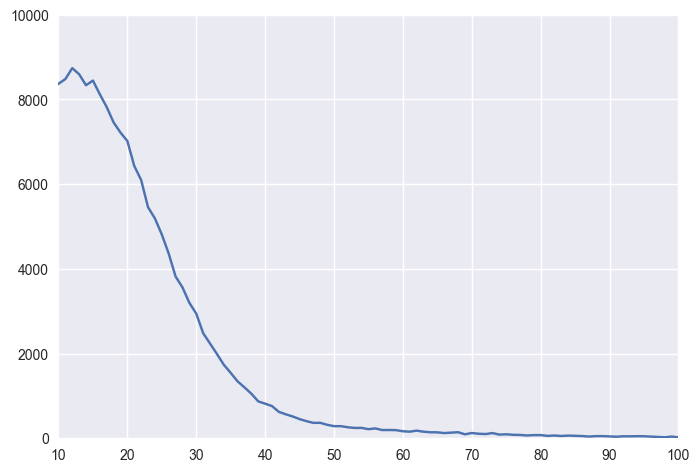

[[ 0 50 47 ... 13  0  0]
 [ 0 36 42 ... 13  6 21]
 [ 0 31 56 ... 12 18  0]
 ...
 [ 0 40 37 ... 13  5 16]
 [ 0 32 35 ...  0  0  3]
 [ 5 28 48 ...  1 11  0]]


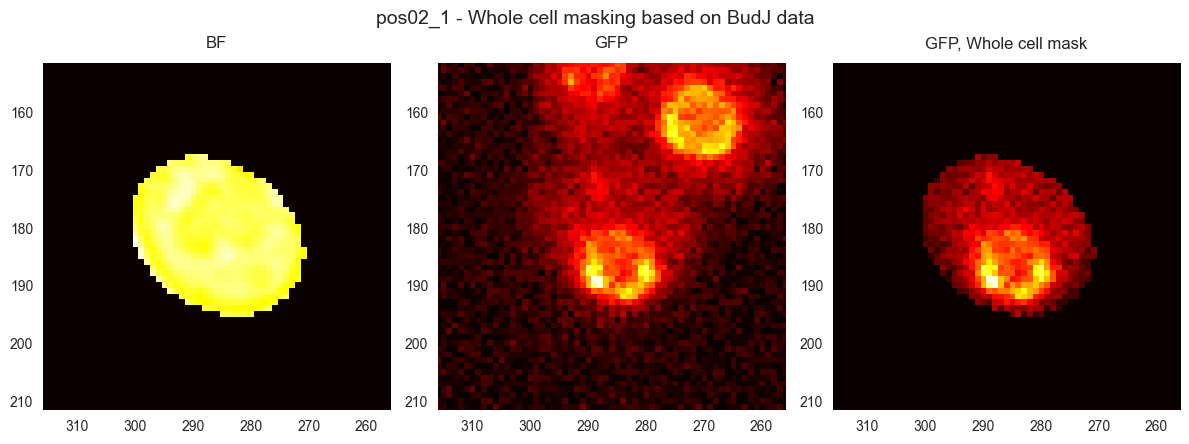

In [133]:
"""
The image channels are split, where after the whole cell mask is created. That, and the
two original channels are plotted, which makes them visually comparable.
"""
pos = "02"
cell_pos = "pos02_1"

# This image variable is a 4 dimensional array. The outer array of 150 length holds matrices of
# 512 by 512 pixels. These each hold 2 values. Index 0: BF channel, index 1: GFP channel
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

# let's take cell 2 of position 01 as example
cell = 1

print(f"Lets take a look at cell {cell_pos}.")

# get the data for the single cell
single_cell_data = budj_data[budj_data["Cell_pos"] == cell_pos]

t = 16
t_in_tiff = t - 1  # skew the time by one

imageBF = image[t_in_tiff, 0, :, :]
imageGFP = image[t_in_tiff, 1, :, :]
print(f"The imageGFP max and min intensities are {imageGFP.max()} and {imageGFP.min()}, respectively.")

# get the whole cell mask
whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

hist, center = exposure.histogram(imageGFP)
plt.plot(hist)
plt.xlim(10, 100)
plt.ylim(0, 10000)
plt.show()
print(imageGFP)

# plot the regular BF and GFP channels and compare this to the masked whole cell (based on ImageJ data)
to_plot = [
    ["BF", imageBF * whole_cell_mask, "hot"],
    ["GFP", imageGFP, "hot"],
    ["GFP, Whole cell mask",  imageGFP * whole_cell_mask, "hot"]
]
plot_from_list(f"{cell_pos} - Whole cell masking based on BudJ data", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

### Comparing multiple thresholding methods
Here we compare multiple thresholding methodologies. This is done on multiple randomly chosen cells. Local thresholding generates a threshold mask image based on local pixel neighborhood. The algorithm behind Otsu thresholding searches for the threshold that minimizes the intra-class variance to essentially split the pixels into two classes.

Randomly picked cells ['pos18_1'] to perform thresholding on.


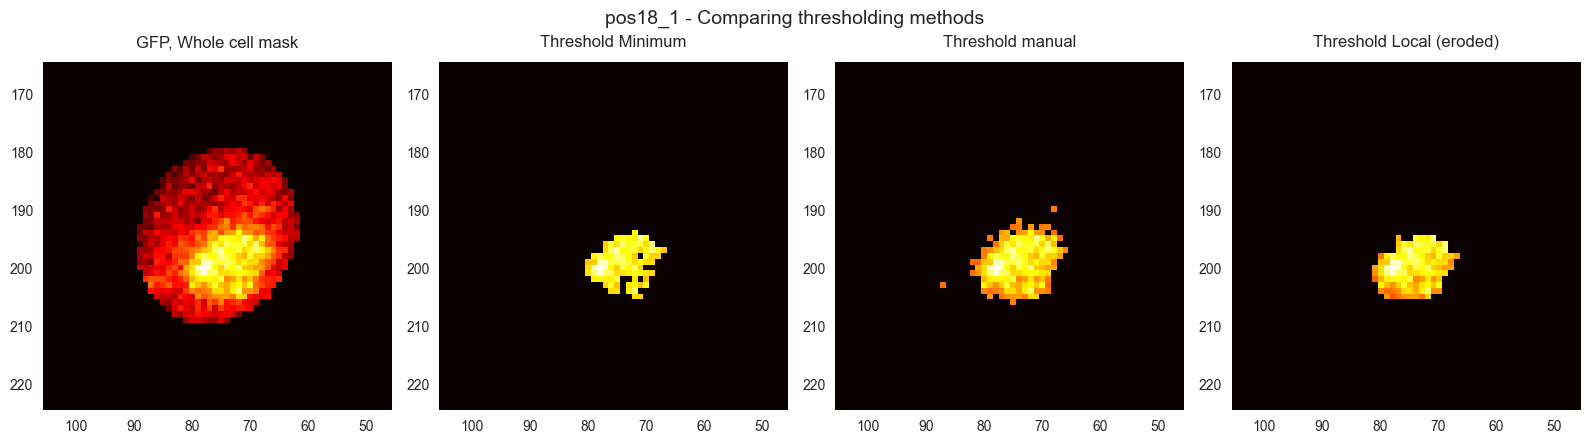

In [119]:
random_cells = random.sample(individual_cells, 1)
print(f"Randomly picked cells {random_cells} to perform thresholding on.")

for cell in random_cells:
    pos = cell[3:5]

    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image
    single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell

    # get the first available frame
    t = single_cell_data['TimeID'].iloc[0]
    t_in_tiff = t - 1

    imageBF = image[t_in_tiff, 0, :, :]
    imageGFP = image[t_in_tiff, 1, :, :]

    whole_cell_mask, x_pos, y_pos = get_whole_cell_mask(t, single_cell_data, imageGFP.shape)

                        # PERFORM DIFFERENT THRESHOLD METHODS
    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    # adaptive thresholding will be performed not on all image but on a fraction of it which includes the cell
    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the GFP channel that is within the cell mask

    # thresholding for getting the nuclear mask
    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    nucl_thresh_mask_otsu = threshold_otsu(imageGFP_cell_mask)  # perform otsu thresholding
    nucl_thresh_mask_minimum = threshold_minimum(imageGFP_cell_mask)  # perform minimum thresholding

    # keep the nucleus pixels that are greater than the local threshold (either with or without erosion)
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_minimum = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_minimum)
    imageGFP_nuc_mask_otsu = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_otsu)
    imageGFP_nuc_mask_manual = imageGFP_cell_mask > 100

    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))
    imageGFP_nuc_mask_local_eroded = remove_small_objects(imageGFP_nuc_mask_local_eroded)

    to_plot = [
        ["GFP, Whole cell mask",  imageGFP * whole_cell_mask],
        ["Threshold Minimum", imageGFP * imageGFP_nuc_mask_minimum],
        ["Threshold manual", imageGFP * imageGFP_nuc_mask_manual],
        ["Threshold Local (eroded)", imageGFP * imageGFP_nuc_mask_local_eroded]
    ]

    plot_from_list(f"{cell} - Comparing thresholding methods", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30))

Notes: local thresholding, after erosion, seems to give the most accurate fit to the nucleus. Minimum thresholding is also performing well, but as you can tell, when the nuclear intensity is not sufficiently high, the minimum method does not result in the desired result at all. In this case, it seems unreliable because of its all-or-nothing nature. Once the piece of investigative code above is run a couple of times, we find that thresholding with erosion performs best.

### Fitting the nuclear ellipse
Using the best thresholding method chosen from options above (Local (eroded) for now)

In [42]:
"""
Function that generates and fits the ellipse using the opencv package. It takes a nuclear mask as argument.
"""
def get_ellipse(imageRFP, nuc_mask):
    mask = imageRFP * nuc_mask
    thresh = mask.astype(np.uint8)  # change type to uint8

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    # if there is a contour found
    if len(contours) > 0:
        cnt = max(contours,key=len)
        if len(cnt) > 4:
            return cv2.fitEllipse(cnt)

Using the above created get_ellipse function, we now plot the original RFP channel, the two versions of nuclear thresholding (non-eroded and eroded) and the fitted ellipse all in one figure to provide an overview of the performance.

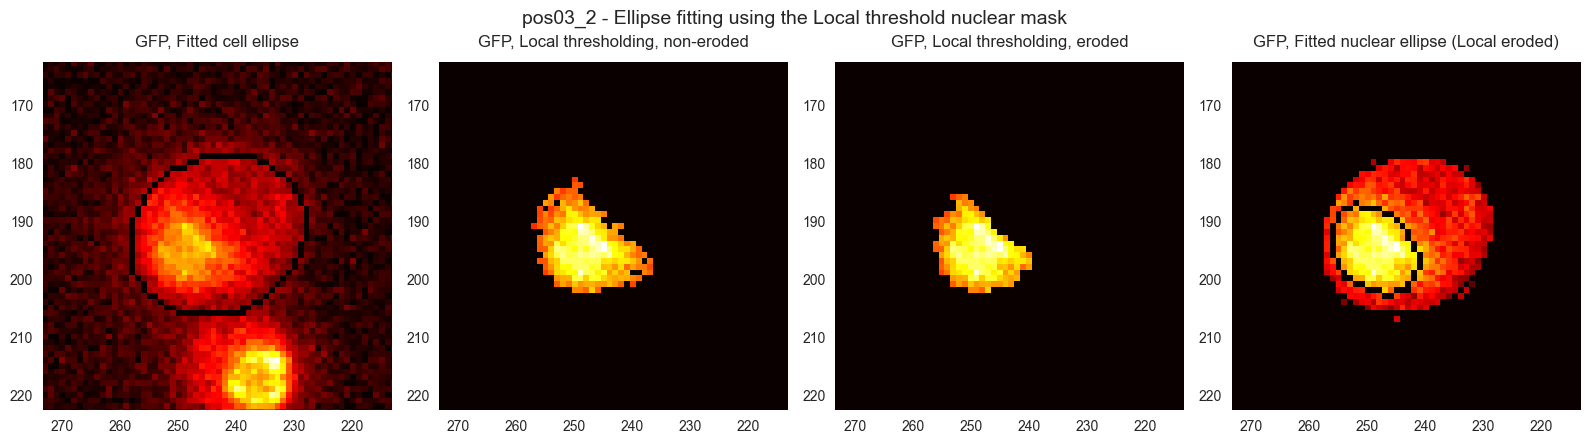

The major and minor axes of the ellipse are 17.45986557006836 and 12.942615509033203, respectively.


In [26]:
# TODO Only for the last processed cell above
# get the nuclear ellipse
(x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local_eroded)  # use imageRFP and nuc_mask_otsu from last plotted cell above
cv2_ellipse = ((x, y), (MA, ma), angle)

(c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)
cv2_ellipse_cell = ((c_x, c_y), (c_MA, c_ma), c_angle)

# plot side by side
to_plot = [
    ["GFP, Fitted cell ellipse", cv2.ellipse(imageGFP, cv2_ellipse_cell, (0, 0, 0), 1)], # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
    ["GFP, Local thresholding, non-eroded", imageGFP * imageGFP_nuc_mask_local],
    ["GFP, Local thresholding, eroded", imageGFP * imageGFP_nuc_mask_local_eroded],
    ["GFP, Fitted nuclear ellipse (Local eroded)", cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1)] # arguments: 1, image data 2, fitted ellipse 3, color (BGR), 4, linewidth
]
plot_from_list(f"{cell} - Ellipse fitting using the Local threshold nuclear mask", to_plot, (x_pos + 30, x_pos - 30), (y_pos + 30, y_pos - 30), False)

print(f"The major and minor axes of the ellipse are {ma} and {MA}, respectively.")

### Ellipse fitting performance over time
To get an insight in how well our nuclear thresholding approach performs, the following code block generates the fitted nuclear ellipse for all timepoints for a particular cell. The figure is saved to the Data/Output folder.

In [35]:
ellipses = []
cell = "pos13_1"
pos = cell[3:5]
image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif"))

single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # pick only the data of the first cell

print(f"Generating ellipse fit overview for cell {cell} ..")
first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

timerange = [i for i in range(first_t, last_t)]
for t in timerange:
    # skew the time by one for tiff dataframe
    t_in_tiff = t - 1

    # get/calculate the ellipse information
    x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

    imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
    y_dim, x_dim = imageGFP.shape  # get the dimensions

    # create an ogrid that helps us select/'mask' the info we want
    row, col = np.ogrid[:y_dim, :x_dim]

    # get the mask of the whole cell
    whole_cell_mask = (
        (
            (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
             +
            (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
        ) # if this sum
        < 0  # is smaller than zero
    )

    imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

    num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
    bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

    nucl_thresh_mask_local = threshold_local(  # local thresholding
        image=imageGFP_cell_mask,
        block_size=bloc_size_cell_size_dependent,
        method='gaussian',
        offset=offset_to_use,
        mode='reflect'
    )
    imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
    imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

    try:
        (x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local_eroded)
        cv2_ellipse = ((x, y), (MA, ma), angle)
    except TypeError:
        print(f"Failed to get ellipse for {cell} at t={t}")
        continue

    # also fit an ellipse on the whole cell mask
    (c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)

    # print(f"Cell area: {(np.sum(whole_cell_mask)) * scaling_factor**2}, nuclear area: {pi * (MA * scaling_factor) * (ma * scaling_factor) / 4}")
    # TODO Since the cell volume is heavily underestimated, I chose to ignore the majorR and minorR from the BudJ data, and got them from fitting an ellipse as well.
    r1c = (c_MA * scaling_factor) # to get the semi-major axis
    r2c = (c_ma * scaling_factor) # to get the semi-minor axis
    r3c = (np.min((c_MA, c_ma)) * scaling_factor) # to get the third axis (average of two known axes)
    cell_volume = (4/3) * pi * r1c * r2c * r3c

    r1n = (MA * scaling_factor) # to get the semi-major axis
    r2n = (ma * scaling_factor) # to get the semi-minor axis
    r3n = (np.min((MA, ma)) * scaling_factor) # to get the third axis (average of two known axes)
    nuc_volume = (4/3) * pi * r1n * r2n * r3n
    # save the fitted ellipse for this time-point to a list
    ellipses.append((t, x_pos, y_pos, cv2.ellipse(imageGFP * whole_cell_mask, cv2_ellipse, (0, 0, 0), 1), cell_volume, nuc_volume))

plt.ioff()
fig = plt.figure(
    figsize=(35, 25),
    edgecolor="black",
    frameon=True,
    facecolor="white",
    layout="tight"
).suptitle(f"Cell {cell} - Fitted ellipses over time", fontsize=14, y=0.99)
for ellipse in ellipses:
    subplt = plt.subplot(10, 15, ellipse[0])
    subplt.set_title(label=f"t = {ellipse[0]}, N/Cell = {round(ellipse[5] / ellipse[4], 4)}", y=1.02)
    plt.imshow(ellipse[3], cmap="hot")
    subplt.grid(False)
    plt.xlim(ellipse[1] + 30, ellipse[1] - 30)
    plt.ylim(ellipse[2] + 30, ellipse[2] - 30)
plt.savefig(img_output_dir + f"{cell}_ellipse_over_time.png", dpi=500)

Generating ellipse fit overview for cell pos13_1 ..


### Comparing the volume dynamics of multiple cells over time
#### Generate volume data both whole cell and nuclei

In [ ]:
# variables to store x and y data in that will be plotted per cell
time_vol_dat = []
time_vol_dat_nuc = []

for pos in range(1,21):
    if pos < 10:
        pos = "0"+ str(pos)
    image = imread(os.path.join(f"{tiff_files_dir}2022_12_06_nup133_yegfp_xy{pos}.nd2.tif")) # load the image

    for cell in individual_cells:
        if 'pos'+str(pos) in cell:
            could_not_fit = 0
            print(f"Working with cell {cell} ..")

            single_cell_data = budj_data[budj_data["Cell_pos"] == cell]  # get the data for the single cell
            first_t = single_cell_data['TimeID'].iloc[0]  # first time-point in data
            last_t = single_cell_data['TimeID'].iloc[-1]  # second time-point in data

            cell_volumes = []
            nuc_volumes = []
            timerange = [i for i in range(first_t, last_t)]
            for t in timerange:
                # skew the time by one for tiff dataframe
                t_in_tiff = t - 1

                # get/calculate the ellipse information
                x_pos, y_pos, majorR, minorR, A = ellipse_from_budj(t, single_cell_data, scaling_factor)

                imageGFP = image[t_in_tiff, 1, :, :] # get the GFP data
                y_dim, x_dim = imageGFP.shape  # get the dimensions

                # create an ogrid that helps us select/'mask' the info we want
                row, col = np.ogrid[:y_dim, :x_dim]

                # get the mask of the whole cell
                whole_cell_mask = (
                    (
                        (((col - x_pos) * cos(A) + (row - y_pos) * sin(A)) ** 2) / (majorR ** 2)
                         +
                        (((col - x_pos) * sin(A) - (row - y_pos) * cos(A)) ** 2) / (minorR ** 2) - 1
                    ) # if this sum
                    < 0  # is smaller than zero
                )

                imageGFP_cell_mask = imageGFP * whole_cell_mask  # keep the part of the RFP channel that is within the cell mask

                num_cell_pixels = np.count_nonzero(whole_cell_mask == True)
                bloc_size_cell_size_dependent = round_up_to_odd(bloc_size_frac_to_use * num_cell_pixels)

                nucl_thresh_mask_local = threshold_local(  # local thresholding
                    image=imageGFP_cell_mask,
                    block_size=bloc_size_cell_size_dependent,
                    method='gaussian',
                    offset=offset_to_use,
                    mode='reflect'
                )
                imageGFP_nuc_mask_local = remove_small_objects(imageGFP_cell_mask > nucl_thresh_mask_local)
                imageGFP_nuc_mask_local_eroded = binary_erosion(imageGFP_nuc_mask_local, structure = np.ones((2,2)))

                try:
                    (x, y), (MA, ma), angle = get_ellipse(imageGFP, imageGFP_nuc_mask_local_eroded)
                    cv2_ellipse = ((x, y), (MA, ma), angle)
                except Exception:
                    could_not_fit += 1
                    continue

                # also fit an ellipse on the whole cell mask
                (c_x, c_y), (c_MA, c_ma), c_angle = get_ellipse(imageGFP, whole_cell_mask)

                # print(f"Cell area: {(np.sum(whole_cell_mask)) * scaling_factor**2}, nuclear area: {pi * (MA * scaling_factor) * (ma * scaling_factor) / 4}")
                # TODO Since the cell volume is heavily underestimated, I chose to ignore the majorR and minorR from the BudJ data, and got them from fitting an ellipse as well.
                r1c = (c_MA * scaling_factor) # to get the semi-major axis
                r2c = (c_ma * scaling_factor) # to get the semi-minor axis
                r3c = (np.min((c_MA, c_ma)) * scaling_factor) # to get the third axis (average of two known axes)
                cell_volume = (4/3) * pi * r1c * r2c * r3c

                r1n = (MA * scaling_factor) # to get the semi-major axis
                r2n = (ma * scaling_factor) # to get the semi-minor axis
                r3n = (np.min((MA, ma)) * scaling_factor) # to get the third axis (average of two known axes)
                nuc_volume = (4/3) * pi * r1n * r2n * r3n

                # append volumes for this datapoint to list holding volumes for all timepoints
                cell_volumes.append(cell_volume)
                nuc_volumes.append(nuc_volume)
            # append the data series for this cell to the list holding it for all cells
            time_vol_dat.append((cell, cell_volumes))
            time_vol_dat_nuc.append((cell, nuc_volumes))
            print(f"Couldn't fit ellipse {could_not_fit} out of {len(timerange)} times")

In [45]:
# print some metrics on the data
print(f"The lengths of the cell volume and nuclear volume data are {len(time_vol_dat)} and {len(time_vol_dat_nuc)}, respectively.")

The lengths of the cell volume and nuclear volume data are 46 and 46, respectively.


#### Plot the generated whole-cell volume data

In [48]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Total cell volumes over time", fontsize=16, y=1)

# plot in a grid
count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig(img_output_dir + "cells_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Plot the generated nuclear volume data

In [49]:
# create figure 3 by 5
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20,30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat_nuc[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].set_title(f"{time_vol_dat_nuc[count][0]}", fontstyle='italic', y=1.02)
            count += 1
plt.savefig(img_output_dir + "nuc_volumes_overT.png", bbox_inches='tight', dpi=350)
plt.close(fig)

#### Combine the volumes
Now plot the nuclear and whole cell volumes in one figure and save this instead of plotting it here.

In [56]:
plt.ioff()
fig, ax = plt.subplots(10, 5, figsize=(20, 30))
fig.subplots_adjust(hspace=0.35, wspace=0.4)
# fig.suptitle("Cell and nuclear volumes over time", fontsize=16)

count = 0
for i in range(10):
    for j in range(5):
        if count < 46:
            volume_data = time_vol_dat[count][1]
            volume_data_nuc = time_vol_dat_nuc[count][1]

            ax[i,j].plot(volume_data)
            ax[i,j].plot(volume_data_nuc)
            ax[i,j].set_title(f"{time_vol_dat[count][0]}", fontstyle='italic', y=1.02)
            count += 1

plt.savefig(img_output_dir + "volumes_overT_together.png", bbox_inches='tight', dpi=350)
plt.close(fig)

Now, let's store a plot that contains the whole cell and nuclear volumes over time in a separate file for all cells

In [65]:
plt.ioff()
count = 0
for cell_volumes in time_vol_dat:
    fig, axs = plt.subplots(2, figsize=(5, 5))
    fig.suptitle(f"{time_vol_dat[count][0]} - Whole cell and nuclear volumes over time")
    volume_data = time_vol_dat[count][1]
    volume_data_nuc = time_vol_dat_nuc[count][1]
    axs[0].plot(volume_data, 'r')
    axs[1].plot(volume_data_nuc, 'y')
    plt.savefig(img_output_dir + f"{time_vol_dat[count][0]}_volumes_overT.png", bbox_inches='tight', dpi=200)
    plt.close(fig)
    count += 1